Redline Tuner

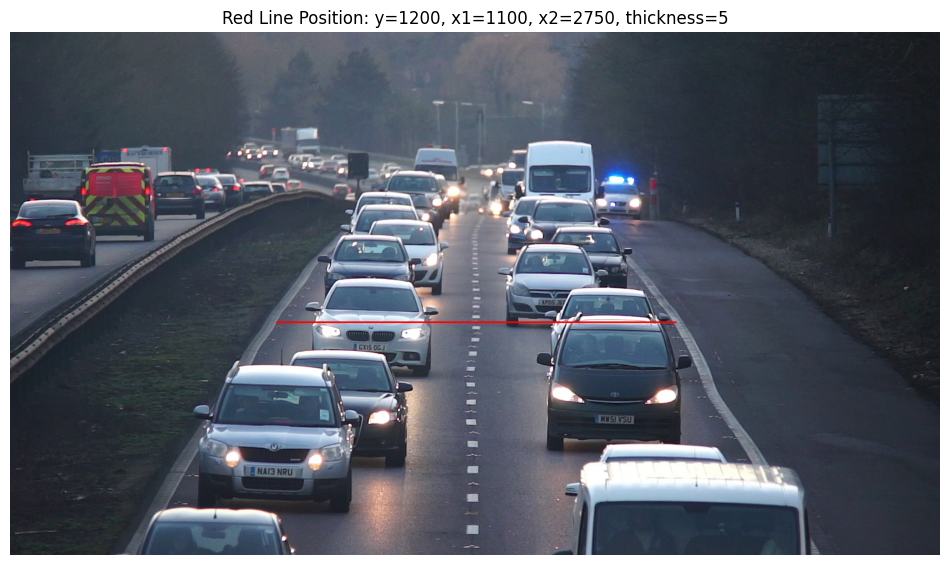

Final settings - Y: 1200, X1: 1100, X2: 2750, Thickness: 5


In [7]:
import cv2
import matplotlib.pyplot as plt

# Open video and get first frame
cap = cv2.VideoCapture('videos/sam.mp4')
ret, frame = cap.read()
cap.release()

# Current values - adjust these and re-run
line_y_red = 1200  # Up/Down: decrease/increase
x1 = 1100           # Left/Right: decrease/increase  
x2 = 2750          # Length
thickness = 5      # Line thickness

# Draw red line
cv2.line(frame, (x1, line_y_red), (x2, line_y_red), (0, 0, 255), thickness)

# Display
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title(f"Red Line Position: y={line_y_red}, x1={x1}, x2={x2}, thickness={thickness}")
plt.axis('off')
plt.show()

print(f"Final settings - Y: {line_y_red}, X1: {x1}, X2: {x2}, Thickness: {thickness}")

Detection, Tracking and Counting with Yolo11

In [ ]:
import cv2
from ultralytics import YOLO
from collections import defaultdict
import os

# Create output directory
output_dir = "results/obj/1"
os.makedirs(output_dir, exist_ok=True)

# Load the YOLO model
model = YOLO('yolo11l.pt')
class_list = model.names

# Open the video file
cap = cv2.VideoCapture('videos/sam.mp4')

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Set up video writer with better error handling
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_path = f'{output_dir}/tracked_video.mp4'
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

if not out.isOpened():
    print("Failed to open video writer. Check codec and file path.")
    cap.release()
    exit()

# Line configuration
line_y_red = 1500
x1 = 850
x2 = 2900
thickness = 5

class_counts = defaultdict(int)
crossed_ids = set()
frame_count = 0
frame_limit = 1800

print(f"Processing {min(frame_limit, total_frames)} frames...")

while cap.isOpened() and frame_count < frame_limit:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    
    # Progress every 50 frames
    if frame_count % 50 == 0:
        progress = (frame_count / frame_limit) * 100
        print(f"Progress: {frame_count}/{frame_limit} frames ({progress:.1f}%)")
    
    # Draw red line
    cv2.line(frame, (x1, line_y_red), (x2, line_y_red), (0, 0, 255), thickness)
   
    # Run YOLO tracking
    results = model.track(frame, persist=True, classes=[1,2,3,5,6,7], verbose=False)
    
    # Track positions for crossing detection
    if results[0].boxes is not None and len(results[0].boxes) > 0:
        boxes = results[0].boxes.xyxy.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist() if results[0].boxes.id is not None else []
        class_indices = results[0].boxes.cls.int().cpu().tolist()
        
        for i, (box, class_idx) in enumerate(zip(boxes, class_indices)):
            if i < len(track_ids):
                track_id = track_ids[i]
                x1_box, y1_box, x2_box, y2_box = map(int, box)
                cy = (y1_box + y2_box) // 2
                class_name = class_list[class_idx]
                
                # Check for crossing
                if cy > line_y_red and track_id not in crossed_ids:
                    crossed_ids.add(track_id)
                    class_counts[class_name] += 1
    
    # Only draw objects that have crossed the line
    if results[0].boxes is not None and len(results[0].boxes) > 0:
        boxes = results[0].boxes.xyxy.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist() if results[0].boxes.id is not None else []
        class_indices = results[0].boxes.cls.int().cpu().tolist()
        
        for i, (box, class_idx) in enumerate(zip(boxes, class_indices)):
            if i < len(track_ids):
                track_id = track_ids[i]
                
                # Only draw if this ID has crossed
                if track_id in crossed_ids:
                    x1_box, y1_box, x2_box, y2_box = map(int, box)
                    cx = (x1_box + x2_box) // 2
                    cy = (y1_box + y2_box) // 2
                    class_name = class_list[class_idx]
                    
                    cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                    cv2.putText(frame, f"ID: {track_id} {class_name}", (x1_box, y1_box - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
                    cv2.rectangle(frame, (x1_box, y1_box), (x2_box, y2_box), (0, 255, 0), 2)
    
    # Display counts
    y_offset = 30
    for class_name, count in class_counts.items():
        cv2.putText(frame, f"{class_name}: {count}", (50, y_offset),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        y_offset += 30
    
    # Write frame to video
    out.write(frame)

# Release resources
cap.release()
out.release()

print(f"\nProcessing complete!")
print(f"Video saved to {output_path}")
print(f"Final counts: {dict(class_counts)}")
print(f"Total objects counted: {sum(class_counts.values())}")

Processing 1800 frames...
Progress: 50/1800 frames (2.8%)
Progress: 100/1800 frames (5.6%)
Progress: 150/1800 frames (8.3%)
Progress: 200/1800 frames (11.1%)
Progress: 250/1800 frames (13.9%)
Progress: 300/1800 frames (16.7%)
Progress: 350/1800 frames (19.4%)
Progress: 400/1800 frames (22.2%)
Progress: 450/1800 frames (25.0%)
Progress: 500/1800 frames (27.8%)
Progress: 550/1800 frames (30.6%)
Progress: 600/1800 frames (33.3%)
Progress: 650/1800 frames (36.1%)
Progress: 700/1800 frames (38.9%)
Progress: 750/1800 frames (41.7%)
Progress: 800/1800 frames (44.4%)
Progress: 850/1800 frames (47.2%)
Progress: 900/1800 frames (50.0%)
Progress: 950/1800 frames (52.8%)
Progress: 1000/1800 frames (55.6%)
Progress: 1050/1800 frames (58.3%)
Progress: 1100/1800 frames (61.1%)
Progress: 1150/1800 frames (63.9%)
Progress: 1200/1800 frames (66.7%)
Progress: 1250/1800 frames (69.4%)
Progress: 1300/1800 frames (72.2%)
Progress: 1350/1800 frames (75.0%)
Progress: 1400/1800 frames (77.8%)
Progress: 1450/18